## <center> 图注意力网络-GAT

### 一、图注意力层

在带有噪声的图中，边的权重不一定能反应两个节点连接的真实强度。这时通过注意力机制$a:R^{F'}\times R^{F'} \rightarrow R$，我们可以定义两个节点$i,j$之间的注意力系数来表达两节点之间的关系：
$$e_{ij} = a(WH_i^{k-1},WH_j^{k-1})$$
这里的$a$可以取很简单的操作，比如向量内积，也可以取相对复杂的操作（见后）。图注意力层在每个节点上应用的先行变换$W$是共享的。获得了连接强度后，为了使不同节点的系数具有可比性，我们可以将注意力系数归一化：
$$\alpha_{ij} = \mathrm{Softmax}_j(\{e_{ij}\}) = \frac{\exp(e_{ij})}{\sum_{l \in N(i)}\exp(e_{il})}$$

除了这种定义方法，我们还有其他的定义方法，以Velickovic et al在2018年所做的研究为例，其注意力分数的计算公式为：
$$\alpha_{ij} = \frac{\exp(\mathrm{LeakyReLU}(W_2[WH_i^{k-1}||WH_j^{k-1}]))}{\sum_{l \in N(i)}\exp(\mathrm{LeakyReLU}(W_2[WH_i^{k-1}||WH_l^{k-1}]))}$$

$\mathrm{LeakyReLU}$是一类非线性激活函数，这里的$W_2 \in R^{1 \times 2F'}$是权重向量的线性变换，"||"操作代表向量之间的聚合，比如在列方向上对两个$V_1,V_2 \in R^{F' \times 1}$执行聚合就会得到新的向量$V = V_1 || V_2 \in R^{2F' \times 1}$

在获得注意力分数$\alpha_{ij}$后，我们就可以获得更新的节点表征：
$$H_i^k = \sigma(\sum_{j \in N(i)} \alpha_{ij} W H_{j}^{k-1})$$

Original node features:
[[ 0.80760886  0.85378257  0.54508255]
 [ 0.20282061 -0.06191314 -3.14658766]
 [ 0.75993008  0.72287152  1.835311  ]
 [ 0.83564012  0.37692411 -0.92172922]
 [ 0.84815302 -0.33547405  0.10709798]]

Updated node features:
[[-0.55723759  0.95674834  0.00396074  0.97233996]
 [-0.53530746 -0.66973774 -0.70592222 -0.93184097]
 [-0.6157072   0.8433492  -0.30155268  0.78632109]
 [-0.48607587  0.93246731  0.01618911  0.97047532]
 [-0.51400376  0.48081913 -0.40432508  0.67941194]]


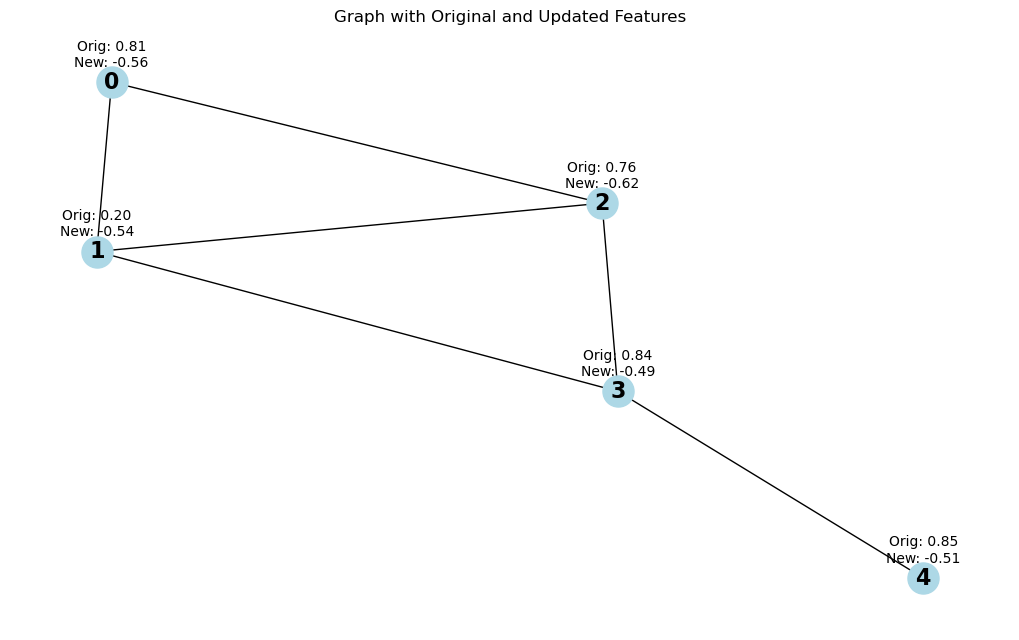

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def create_graph():
    """Create a simple graph for demonstration."""
    G = nx.Graph()
    G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4)])
    return G

def leaky_relu(x, alpha=0.2):
    """Leaky ReLU activation function."""
    return np.maximum(alpha * x, x)

def softmax(x, axis=None):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def gat_attention_coefficients(H, W, a, neighbors):
    """
    Compute attention coefficients for Graph Attention Network.
    
    :param H: Node features
    :param W: Weight matrix for linear transformation
    :param a: Weight vector for attention mechanism
    :param neighbors: List of neighbors for each node
    :return: Dictionary of attention coefficients for each node's neighbors
    """
    N, F = H.shape
    F_prime = W.shape[1]
    
    # Linear transformation of node features
    WH = np.dot(H, W)
    
    attention_coeffs = {}
    for i in range(N):
        coeffs = []
        for j in neighbors[i]:
            # Concatenate features and apply attention mechanism
            concat_features = np.concatenate([WH[i], WH[j]])
            e_ij = leaky_relu(np.dot(a, concat_features))
            coeffs.append(e_ij)
        
        # Apply softmax to get normalized attention coefficients
        attention_coeffs[i] = softmax(np.array(coeffs))
    
    return attention_coeffs

def update_node_features(H, W, attention_coeffs, neighbors):
    """
    Update node features using attention mechanism.
    
    :param H: Current node features
    :param W: Weight matrix for linear transformation
    :param attention_coeffs: Attention coefficients for each node's neighbors
    :param neighbors: List of neighbors for each node
    :return: Updated node features
    """
    N, F = H.shape
    F_prime = W.shape[1]
    H_prime = np.zeros((N, F_prime))
    
    for i in range(N):
        weighted_sum = np.zeros(F_prime)
        for j, alpha in zip(neighbors[i], attention_coeffs[i]):
            weighted_sum += alpha * np.dot(W.T, H[j])
        H_prime[i] = np.tanh(weighted_sum)  # Using tanh as activation function
    
    return H_prime

# Create graph
G = create_graph()

# Get adjacency list
adj_list = {node: list(G.neighbors(node)) for node in G.nodes()}

# Create random node features (5 nodes, 3 features each)
H = np.random.randn(5, 3)

# Create random weight matrices
W = np.random.randn(3, 4)  # Transform from 3 features to 4
a = np.random.randn(8)  # Attention mechanism weight vector (2 * 4 = 8)

# Compute attention coefficients
attention_coeffs = gat_attention_coefficients(H, W, a, adj_list)

# Update node features
H_prime = update_node_features(H, W, attention_coeffs, adj_list)

print("Original node features:")
print(H)
print("\nUpdated node features:")
print(H_prime)

# Visualize the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')

# Add original and updated feature values to the plot
for node, (x, y) in pos.items():
    plt.text(x, y+0.1, f'Orig: {H[node,0]:.2f}\nNew: {H_prime[node,0]:.2f}', ha='center', va='center')

plt.title("Graph with Original and Updated Features")
plt.show()

### 二、多头注意力机制
通过使用多头注意力机制，我们可以在同一层网络中调用不同的相似度函数$a$，这增加了网络的表达能力。具体的，多头注意力机制在数学上可以写为：
$$H_i^k = ||_{t=1}^{T} \sigma(\sum_{j \in N(i)} \alpha_{ij}^t W^t H_j^{k-1})$$
公式中$T$是注意力头的总数，$\alpha_{ij}^t$是由$t$个注意力头计算的注意力系数，$W^t$是第$t$个注意力头的变换矩阵。值得注意的是，在网络的最后一层结合来自不同的注意力头的节点表征时，可以使用其他pooling技术，不一定要向量聚合。比如可以获取平均节点表征：
$$H_i^k = \sigma(\frac{1}{T}\sum_{t=1}^{T}\sum_{j \in N(i)}\alpha_{ij}^tW^tH_{j}^{k-1})$$

Original node features:
[[-0.7486472  -0.54905706  0.4853619 ]
 [-0.1220711   1.13743695 -0.89461164]
 [-0.91001951  1.2147049  -1.69864494]
 [ 0.11300946 -0.95296731 -0.63584755]
 [ 1.17765935  0.41411651  2.16853664]]

Updated node features (concatenation):
[[-0.9942252   0.89055763  0.99805568 -0.42428203  0.93897955 -0.79956813
  -0.81680596  0.09290082 -0.79893127 -0.34406048 -0.94217873  0.98992278]
 [ 0.20822528 -0.12244722  0.90462274 -0.65587361  0.9487976   0.8146304
   0.73765907 -0.27724804 -0.36262848  0.22094259 -0.77096717 -0.4140357 ]
 [-0.94569711  0.7749293   0.97616338 -0.44066949  0.94683748  0.81973784
   0.74756192 -0.2834793  -0.21894346  0.21453781 -0.67048744 -0.54302583]
 [-0.81495045  0.68321402 -0.97747036  0.85527214  0.95280289 -0.78851835
  -0.82767187  0.12378415 -0.49534227 -0.34708712 -0.57090212  0.96589401]
 [ 0.96275763 -0.58654957  0.29218917 -0.84778818  0.95956094  0.82857102
   0.84215636 -0.4652543  -0.19995928  0.32079447 -0.93945095 -0.829790

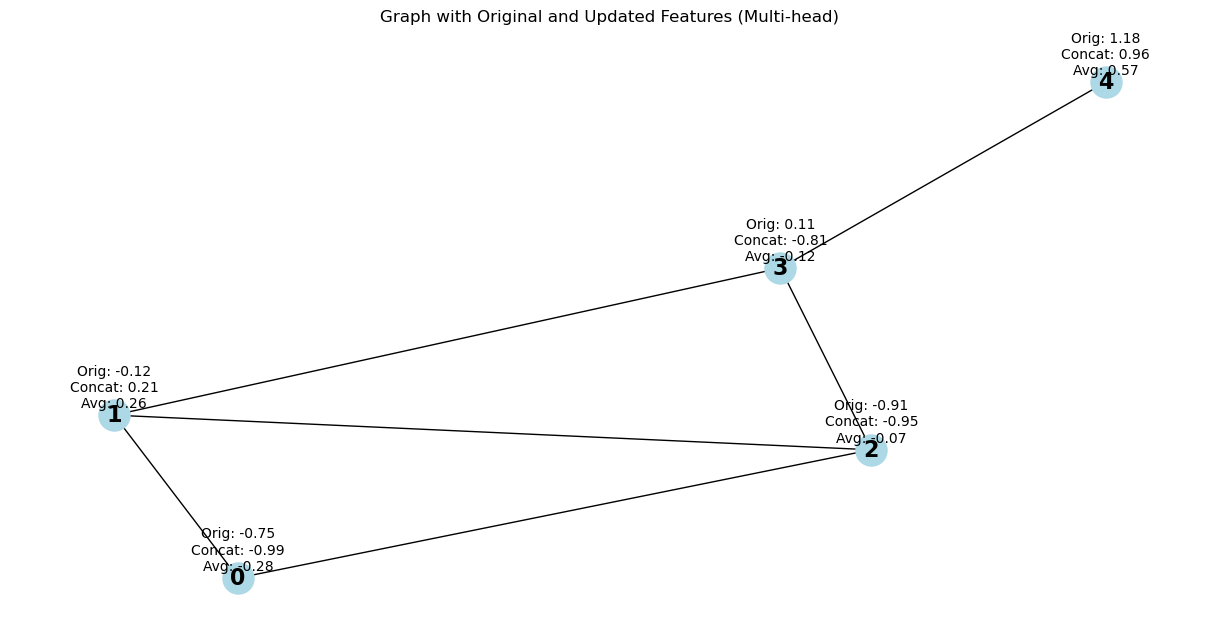

In [2]:
# multi-head attention
def multi_head_attention_coefficients(H, W_list, a_list, neighbors):
    """
    Compute attention coefficients for multi-head Graph Attention Network.
    
    :param H: Node features
    :param W_list: List of weight matrices for linear transformations
    :param a_list: List of weight vectors for attention mechanisms
    :param neighbors: List of neighbors for each node
    :return: List of dictionaries of attention coefficients for each head
    """
    N, F = H.shape
    T = len(W_list)  # Number of attention heads
    
    all_attention_coeffs = []
    
    for t in range(T):
        W = W_list[t]
        a = a_list[t]
        F_prime = W.shape[1]
        
        # Linear transformation of node features
        WH = np.dot(H, W)
        
        attention_coeffs = {}
        for i in range(N):
            coeffs = []
            for j in neighbors[i]:
                # Concatenate features and apply attention mechanism
                concat_features = np.concatenate([WH[i], WH[j]])
                e_ij = leaky_relu(np.dot(a, concat_features))
                coeffs.append(e_ij)
            
            # Apply softmax to get normalized attention coefficients
            attention_coeffs[i] = softmax(np.array(coeffs))
        
        all_attention_coeffs.append(attention_coeffs)
    
    return all_attention_coeffs

def update_node_features_multi_head(H, W_list, all_attention_coeffs, neighbors, aggregation='concat'):
    """
    Update node features using multi-head attention mechanism.
    
    :param H: Current node features
    :param W_list: List of weight matrices for linear transformations
    :param all_attention_coeffs: List of attention coefficients for each head
    :param neighbors: List of neighbors for each node
    :param aggregation: Method to aggregate multiple heads ('concat' or 'average')
    :return: Updated node features
    """
    N, F = H.shape
    T = len(W_list)  # Number of attention heads
    F_prime = W_list[0].shape[1]
    
    if aggregation == 'concat':
        H_prime = np.zeros((N, F_prime * T))
    else:  # 'average'
        H_prime = np.zeros((N, F_prime))
    
    for t in range(T):
        W = W_list[t]
        attention_coeffs = all_attention_coeffs[t]
        
        for i in range(N):
            weighted_sum = np.zeros(F_prime)
            for j, alpha in zip(neighbors[i], attention_coeffs[i]):
                weighted_sum += alpha * np.dot(W.T, H[j])
            
            if aggregation == 'concat':
                H_prime[i, t*F_prime:(t+1)*F_prime] = np.tanh(weighted_sum)
            else:  # 'average'
                H_prime[i] += np.tanh(weighted_sum)
    
    if aggregation == 'average':
        H_prime /= T
    
    return H_prime

G = create_graph()
adj_list = {node: list(G.neighbors(node)) for node in G.nodes()}

# create random node features (5 nodes, 3 features each)
H = np.random.randn(5, 3)

# create random weight matrices
T = 3  # 3 attention heads
F_prime = 4  # New feature dimension after attention mechanism

# create random weight matrices and vectors for each head
W_list = [np.random.randn(3, F_prime) for _ in range(T)]
a_list = [np.random.randn(2 * F_prime) for _ in range(T)]

# compute attention coefficients for each head
all_attention_coeffs = multi_head_attention_coefficients(H, W_list, a_list, adj_list)

# update node features (concatenation)
H_prime_concat = update_node_features_multi_head(H, W_list, all_attention_coeffs, adj_list, aggregation='concat')

# update node features (average)
H_prime_avg = update_node_features_multi_head(H, W_list, all_attention_coeffs, adj_list, aggregation='average')

print("Original node features:")
print(H)
print("\nUpdated node features (concatenation):")
print(H_prime_concat)
print("\nUpdated node features (average):")
print(H_prime_avg)

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
for node, (x, y) in pos.items():
    plt.text(x, y+0.1, f'Orig: {H[node,0]:.2f}\nConcat: {H_prime_concat[node,0]:.2f}\nAvg: {H_prime_avg[node,0]:.2f}', ha='center', va='center')

plt.title("Graph with Original and Updated Features (Multi-head)")
plt.show()